<a href="https://colab.research.google.com/github/plaban1981/POCs/blob/main/Question_Answering_with_a_Fine_Tuned_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Answering with a Fine-Tuned BERT


# Part 1: How BERT is applied to Question Answering

## The SQuAD v1.1 Benchmark

When someone mentions "Question Answering" as an application of BERT, what they are really referring to is applying BERT to the Stanford Question Answering Dataset (SQuAD).

The task posed by the SQuAD benchmark is a little different than you might think. Given a question, and *a passage of text containing the answer*, BERT needs to highlight the "span" of text corresponding to the correct answer. 

The SQuAD homepage has a fantastic tool for exploring the questions and reference text for this dataset, and even shows the predictions made by top-performing models.

For example, here are some [interesting examples](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/Super_Bowl_50.html?model=r-net+%20(ensemble)%20(Microsoft%20Research%20Asia)&version=1.1) on the topic of Super Bowl 50.


## BERT Input Format

To feed a QA task into BERT, we pack both the question and the reference text into the input.



[![Input format for QA](https://drive.google.com/uc?export=view&id=1dfgTaE_SABpr2blqwTjq9PTyhYabO8_m)](https://drive.google.com/uc?export=view&id=1dfgTaE_SABpr2blqwTjq9PTyhYabO8_m)



The two pieces of text are separated by the special `[SEP]` token. 

BERT also uses "Segment Embeddings" to differentiate the question from the reference text. These are simply two embeddings (for segments "A" and "B") that BERT learned, and which it adds to the token embeddings before feeding them into the input layer. 

[![BERT eBook Display Ad](https://drive.google.com/uc?export=view&id=1d6L584QYqpREpRIwAZ55Wsq8AUs5qSk1)](https://bit.ly/3isUyCt)

## Start & End Token Classifiers

BERT needs to highlight a "span" of text containing the answer--this is represented as simply predicting which token marks the start of the answer, and which token marks the end.

![Start token classification](http://www.mccormickml.com/assets/BERT/SQuAD/start_token_classification.png)

For every token in the text, we feed its final embedding into the start token classifier. The start token classifier only has a single set of weights (represented by the blue "start" rectangle in the above illustration) which it applies to every word.

After taking the dot product between the output embeddings and the 'start' weights, we apply the softmax activation to produce a probability distribution over all of the words. Whichever word has the highest probability of being the start token is the one that we pick.

We repeat this process for the end token--we have a separate weight vector this.

![End token classification](http://www.mccormickml.com/assets/BERT/SQuAD/end_token_classification.png)

# Part 2: Example Code

In the example code below, we'll be downloading a model that's *already been fine-tuned* for question answering, and try it out on our own text.

If you do want to fine-tune on your own dataset, it is possible to fine-tune BERT for question answering yourself. See [run_squad.py](https://github.com/huggingface/transformers/blob/master/examples/run_squad.py) in the `transformers` library. However,you may find that the below "fine-tuned-on-squad" model already does a good job, even if your text is from a different domain. 

> Note: The example code in this Notebook is a commented and expanded version of the short example provided in the `transformers` documentation [here](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertforquestionanswering#transformers.BertForQuestionAnswering).

## 1. Install huggingface transformers library

This example uses the `transformers` [library](https://github.com/huggingface/transformers/) by huggingface. We'll start by installing the package.

In [1]:
!pip install --quiet transformers

     |████████████████████████████████| 3.1 MB 6.6 MB/s 
     |████████████████████████████████| 596 kB 89.0 MB/s 
     |████████████████████████████████| 895 kB 86.5 MB/s 
     |████████████████████████████████| 61 kB 599 kB/s 
     |████████████████████████████████| 3.3 MB 76.5 MB/s 


In [2]:
import torch

## 2. Load Fine-Tuned BERT-large

For Question Answering we use the `BertForQuestionAnswering` class from the `transformers` library.

This class supports fine-tuning, but for this example we will keep things simpler and load a BERT model that has already been fine-tuned for the SQuAD benchmark.

The `transformers` library has a large collection of pre-trained models which you can reference by name and load easily. The full list is in their documentation [here](https://huggingface.co/transformers/pretrained_models.html).

For Question Answering, they have a version of BERT-large that has already been fine-tuned for the SQuAD benchmark. 

BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance. 

(Note that this download is not using your own network bandwidth--it's between the Google instance and wherever the model is stored on the web).

Note: I believe this model was trained on version 1 of SQuAD, since it's not outputting whether the question is "impossible" to answer from the text (which is part of the task in v2 of SQuAD).


In [3]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad',return_dict=False)


Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Load the tokenizer as well. 

Side note: Apparently the vocabulary of this model is identicaly to the one in bert-base-uncased. You can load the tokenizer from `bert-base-uncased` and that works just as well.

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

## 3. Ask a Question

Now we're ready to feed in an example!

A QA example consists of a question and a passage of text containing the answer to that question.

Let's try an example using the text in this tutorial!

In [4]:
question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

In [29]:
question = "When was the first battle of panipat fought"
answer_text = "The First Battle of Panipat, on 21 April 1526, was fought between the invading forces of Babur and the Lodi dynasty. It took place in North India and marked the beginning of the Mughal Empire and the end of the Delhi Sultanate. This was one of the earliest battles involving gunpowder firearms and field artillery in the Indian subcontinent which were introduced by Mughals in this battle."

We'll need to run the BERT tokenizer against both the `question` and the `answer_text`. To feed these into BERT, we actually concatenate them together and place the special [SEP] token in between.


In [5]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 70 tokens.


In [6]:
# Apply the tokenizer to the input text, treating them as a text-pair.
encoded_dict = tokenizer.encode_plus(text=question,text_pair=answer_text)
print('The input has a total of {:} tokens.'.format(len(encoded_dict['input_ids'])))

The input has a total of 91 tokens.


Just to see exactly what the tokenizer is doing, let's print out the tokens with their IDs.

In [7]:
input_ids = encoded_dict['input_ids']
segment_ids = encoded_dict['token_type_ids']
# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

In [8]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
when          2,043
was           2,001
the           1,996
first         2,034
battle        2,645
of            1,997
pan           6,090
##ip         11,514
##at          4,017
fought        4,061

[SEP]           102

the           1,996
first         2,034
battle        2,645
of            1,997
pan           6,090
##ip         11,514
##at          4,017
,             1,010
on            2,006
21            2,538
april         2,258
152          15,017
##6           2,575
,             1,010
was           2,001
fought        4,061
between       2,090
the           1,996
invading     17,657
forces        2,749
of            1,997
babu         20,948
##r           2,099
and           1,998
the           1,996
lo            8,840
##di          4,305
dynasty       5,321
.             1,012
it            2,009
took          2,165
place         2,173
in            1,999
north         2,167
india         2,634
and           1,998
marked        4,417
the           1,99

We've concatenated the `question` and `answer_text` together, but BERT still needs a way to distinguish them. BERT has two special "Segment" embeddings, one for segment "A" and one for segment "B". Before the word embeddings go into the BERT layers, the segment A embedding needs to be added to the `question` tokens, and the segment B embedding needs to be added to each of the `answer_text` tokens. 

These additions are handled for us by the `transformer` library, and all we need to do is specify a '0' or '1' for each token. 

Note: In the `transformers` library, huggingface likes to call these `token_type_ids`, but I'm going with `segment_ids` since this seems clearer, and is consistent with the BERT paper.

In [9]:
encoded_dict

{'input_ids': [101, 2043, 2001, 1996, 2034, 2645, 1997, 6090, 11514, 4017, 4061, 102, 1996, 2034, 2645, 1997, 6090, 11514, 4017, 1010, 2006, 2538, 2258, 15017, 2575, 1010, 2001, 4061, 2090, 1996, 17657, 2749, 1997, 20948, 2099, 1998, 1996, 8840, 4305, 5321, 1012, 2009, 2165, 2173, 1999, 2167, 2634, 1998, 4417, 1996, 2927, 1997, 1996, 17877, 3400, 1998, 1996, 2203, 1997, 1996, 6768, 21308, 1012, 2023, 2001, 2028, 1997, 1996, 5700, 7465, 5994, 22220, 13780, 1998, 2492, 4893, 1999, 1996, 2796, 26125, 2029, 2020, 3107, 2011, 17877, 2015, 1999, 2023, 2645, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

## Not Required

In [ ]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

>*Side Note: Where's the padding?*
>
> The original [example code](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertforquestionanswering#transformers.BertForQuestionAnswering) does not perform any padding. I suspect that this is because we are only feeding in a *single example*. If we instead fed in a batch of examples, then we would need to pad or truncate all of the samples in the batch to a single length, and supply an attention mask to tell BERT to ignore the padding tokens. 

We're ready to feed our example into the model!

Note: The result object is of type [QuestionAnsweringModelOutput](https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.QuestionAnsweringModelOutput)



In [10]:
# Run our example through the model.
import torch
outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                             token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                             return_dict=True) 

start_scores = outputs.start_logits
end_scores = outputs.end_logits


In [11]:
start_scores

tensor([[-6.1921, -7.8888, -8.4645, -8.1532, -8.2352, -8.0632, -8.7318, -8.1105,
         -8.2547, -9.1396, -9.1980, -6.1920,  3.5754,  1.0137, -0.6775, -3.4296,
         -0.8084, -4.3873, -4.1665, -2.1391,  3.9576,  7.3590,  1.6369,  2.0753,
         -1.1646, -4.4231, -1.2428, -0.2542, -1.3991, -3.7001, -2.8558, -4.5216,
         -6.7074, -2.1165, -6.4115, -6.9660, -5.0379, -4.0100, -7.1945, -4.9442,
         -6.1919,  0.7952, -1.8639, -3.8503, -1.9429, -1.1616, -2.0966, -5.1343,
         -0.8202, -3.3836, -3.6776, -6.0500, -4.4275, -3.2622, -5.4394, -6.8803,
         -4.3243, -4.4168, -7.5424, -6.5254, -3.7600, -5.2122, -5.6785, -0.5037,
         -6.0402, -2.5273, -6.6063, -6.3269, -4.0668, -4.5432, -6.2146, -4.8752,
         -5.8722, -8.2681, -6.3960, -6.5612, -7.8046, -7.5089, -4.3424, -6.7015,
         -7.7564, -7.8805, -4.9072, -7.8354, -4.7692, -8.0552, -6.0533, -4.6642,
         -4.3043, -8.7412, -6.1921]], grad_fn=<CloneBackward0>)

In [12]:
end_scores

tensor([[-1.2906, -7.6076, -7.6274, -7.9695, -7.5565, -7.5547, -7.5955, -7.6814,
         -6.9985, -6.2216, -8.6514, -1.2904, -4.4938, -3.8245, -4.1108, -5.8563,
         -4.6906, -4.2343,  2.3269,  0.4567, -2.3111, -1.1959, -0.0603, -0.8008,
          8.3731,  4.1742, -2.9604, -1.5729, -4.1726, -6.0517, -4.4152, -1.9234,
         -6.3897, -5.9848, -1.9510, -6.2458, -7.0643, -6.8189, -3.5232,  1.4079,
         -1.2904, -5.2609, -5.9797, -2.1445, -5.8484, -5.1173,  1.1486, -4.9378,
         -5.5935, -7.0867, -4.9104, -6.6911, -7.2202, -4.7570, -1.4974, -7.0718,
         -7.1866, -5.3730, -6.6655, -7.3449, -4.7993, -0.6807,  0.2394, -6.3728,
         -7.3108, -7.4306, -7.5641, -7.9508, -5.7352, -5.9379, -7.4450, -5.9270,
         -3.3975, -7.5637, -7.2660, -2.6211, -7.5153, -7.7844, -5.4956, -1.4396,
         -6.3828, -7.7750, -6.2637, -8.0213, -7.1848, -4.2321, -7.5771, -7.5525,
         -1.8090, -2.9398, -1.2907]], grad_fn=<CloneBackward0>)

Now we can highlight the answer just by looking at the most probable start and end words. 

In [13]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "21 april 152 ##6"


It got it right! Awesome :)

> *Side Note: It's a little naive to pick the highest scores for start and end--what if it predicts an end word that's before the start word?! The correct implementation is to pick the highest total score for which end >= start.*

With a little more effort, we can reconstruct any words that got broken down into subwords.

In [14]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "21 april 1526"


## 4. Visualizing Scores

I was curious to see what the scores were for all of the words. The following cells generate bar plots showing the start and end scores for every word in the input.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

Retrieve all of the start and end scores, and use all of the tokens as x-axis labels.

In [16]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


Create a bar plot showing the score for every input word being the "start" word.

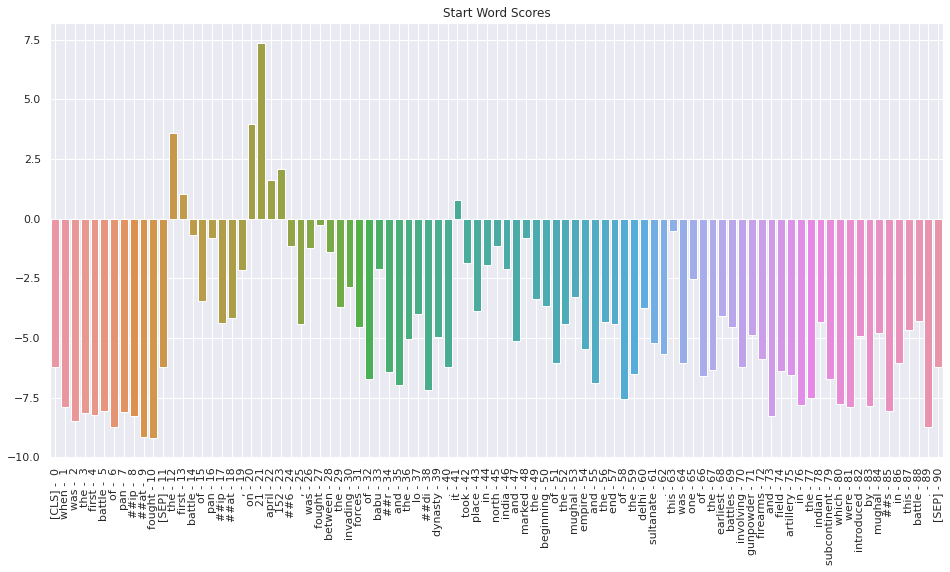

In [17]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

Create a second bar plot showing the score for every input word being the "end" word.

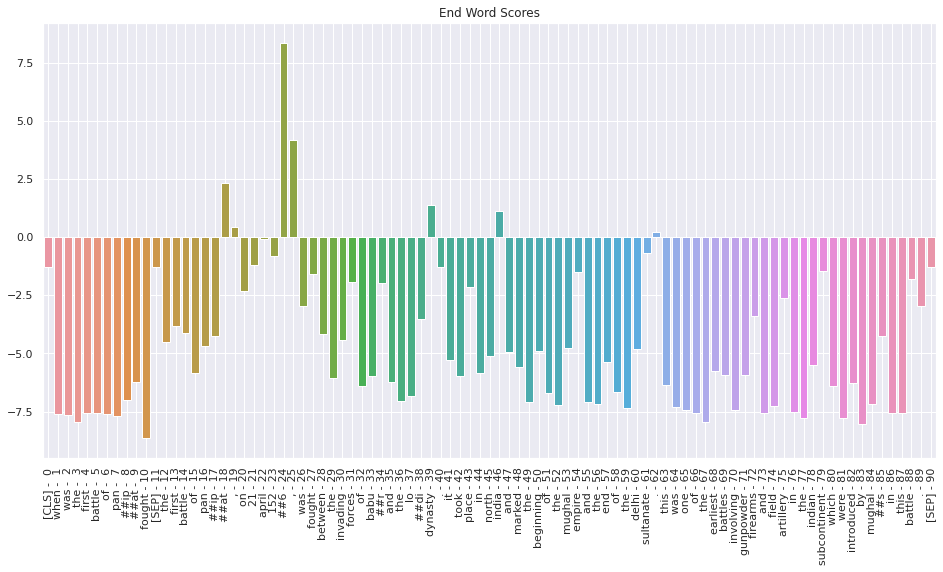

In [18]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

**Alternate View**

I also tried visualizing both the start and end scores on a single bar plot, but I think it may actually be more confusing then seeing them separately. 

In [19]:
import pandas as pd

# Store the tokens and scores in a DataFrame. 
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)


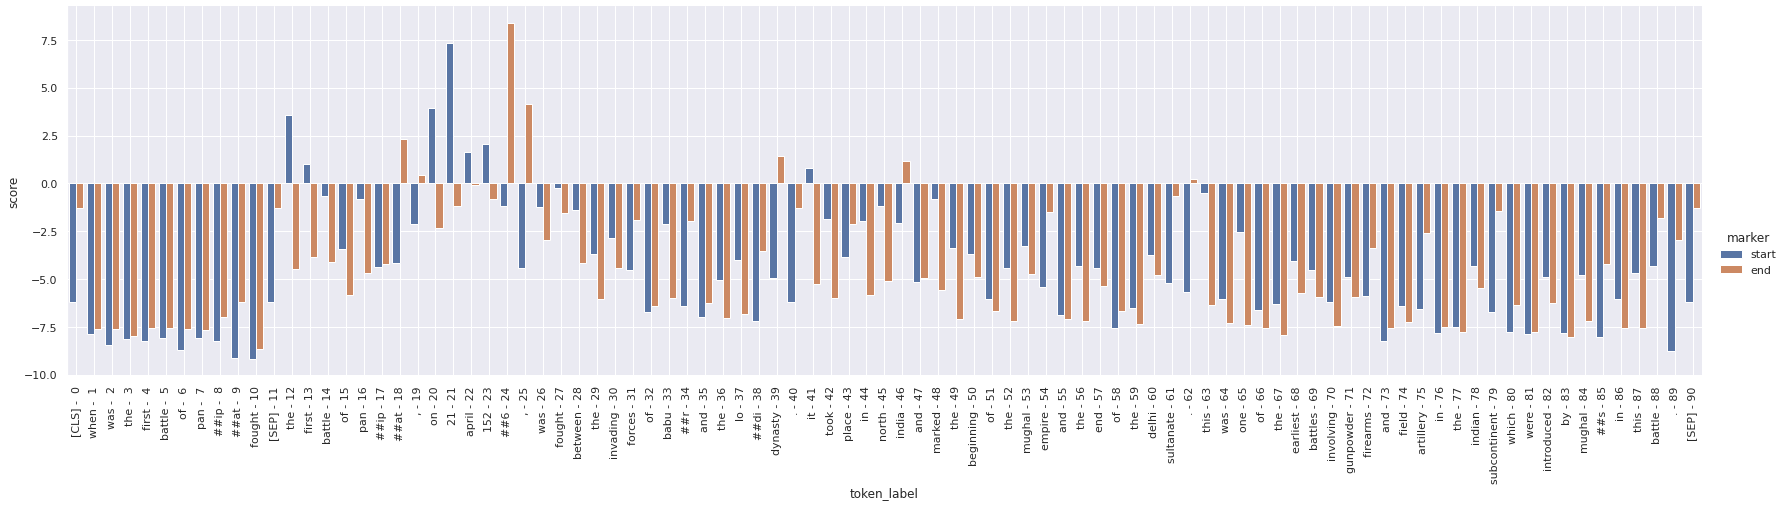

In [20]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)


## 5. More Examples

Turn the QA process into a function so we can easily try out other examples.

In [30]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    encoded_dict = tokenizer.encode_plus(text=question,text_pair=answer_text)
    input_ids = encoded_dict['input_ids']
    segment_ids = encoded_dict['token_type_ids']
    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)
    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))
    # ======== Evaluate ========
    # Run our example through the model.
    outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                    token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                    return_dict=True) 

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')
    return answer

In [31]:
answer_question(question, answer_text)

Query has 91 tokens.

Answer: "21 april 1526"


'21 april 1526'

As our reference text, I've taken the Abstract of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf).


In [23]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))

We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by
jointly conditioning on both left and right context in all layers. As a result,
the pre-trained BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for a wide range of tasks, such as
question answering and language inference, without substantial taskspecific
architecture modifications. BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art results on eleven natural language
processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute
improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1
question answering Test F1 to 93.2 (1.5 point absolute improvement) 

-----------------------------
Ask BERT what its name stands for (the answer is in the first sentence of the abstract).

In [24]:
question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)

Query has 258 tokens.

Answer: "bidirectional encoder representations from transformers"


---------------------
Ask BERT about example applications of itself :)

The answer to the question comes from this passage from the abstract: 

> "...BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for **a wide range of tasks, such as
question answering and language inference,** without substantial taskspecific
architecture modifications."

In [25]:
question = "What are some example applications of BERT?"

answer_question(question, bert_abstract)

Query has 255 tokens.

Answer: "question answering and language inference"


## Building a prtotype using Gradio Web APP

In [26]:
! pip install --quiet gradio

     |████████████████████████████████| 979 kB 9.0 MB/s 
     |████████████████████████████████| 2.0 MB 81.1 MB/s 
     |████████████████████████████████| 206 kB 69.5 MB/s 
     |████████████████████████████████| 63 kB 3.0 MB/s 
     |████████████████████████████████| 961 kB 34.2 MB/s 
     |████████████████████████████████| 3.6 MB 63.4 MB/s 


In [35]:
import gradio as gr
interface = gr.Interface(fn=answer_question,inputs=["text","text"],outputs="text")
interface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://57997.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://57997.gradio.app')

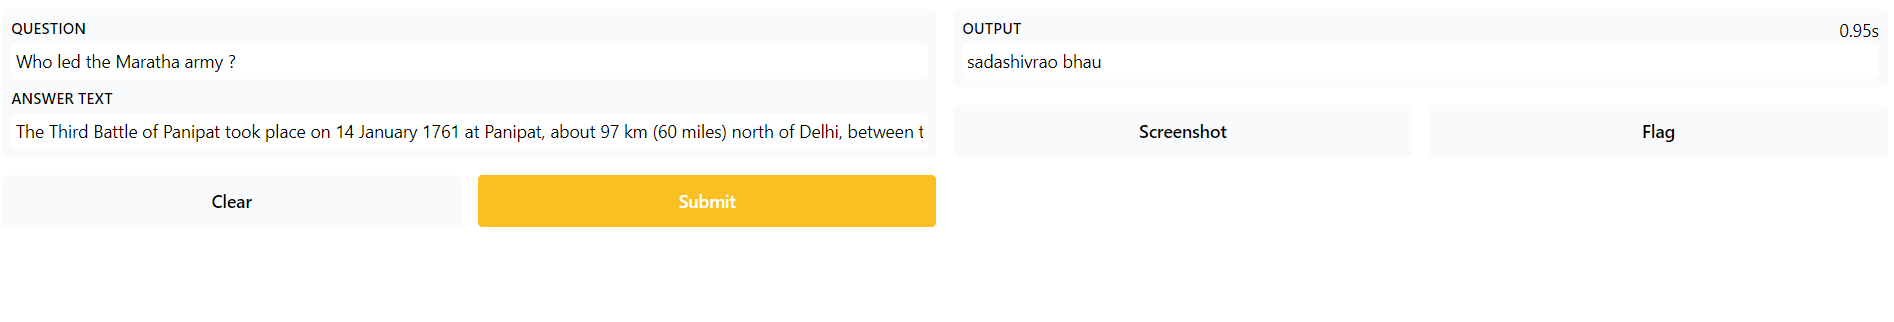

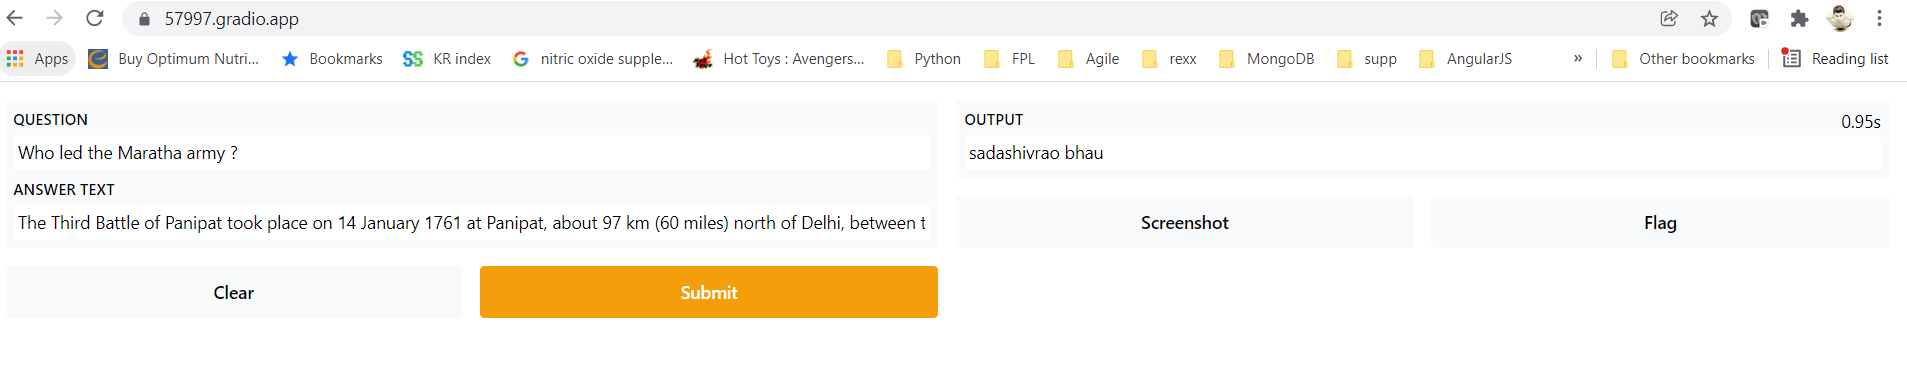